### Overview:
- The purpose of this notebook is to experiment with training our own embedding for SPAFF. The logic behind this is that common embeddings are trained on Wikipedia (GloVe) or Google News (word2vec) text corpuses, both of which differ from conversational english. Training an embedding on conversation data may provide a more relevant embedding.
- Training embeddings requires a lot of data. To augment SPAFF data, I am adding IEMOCAP and SWBD transcripts to the dataset, both of which are 2-party converstational transcripts.
- In total, our model was trained on 1,911,806 tokens (28,940 unique tokens) from 272,599 utterances.

In [1]:
from gensim.models import Word2Vec, phrases
from gensim.models import KeyedVectors

from sklearn.decomposition import PCA
from matplotlib import pyplot
import pandas as pd
import glob
import string
import re

### Load in SPAFF text

In [2]:
transcript_path = glob.glob('/Users/asi/connor_asi/spaff_data/cleaned_spaff_level_transcripts/*')
df_list = []
for i in transcript_path:
    d = pd.read_csv(i)
    df_list.append(d)
df = pd.concat(df_list)
utterances = df.words_no_nan_no_punc_lower.tolist()
spaff_split_utterances = []
for i in utterances:
    u = i.split('  ')
    spaff_split_utterances.append(u)

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


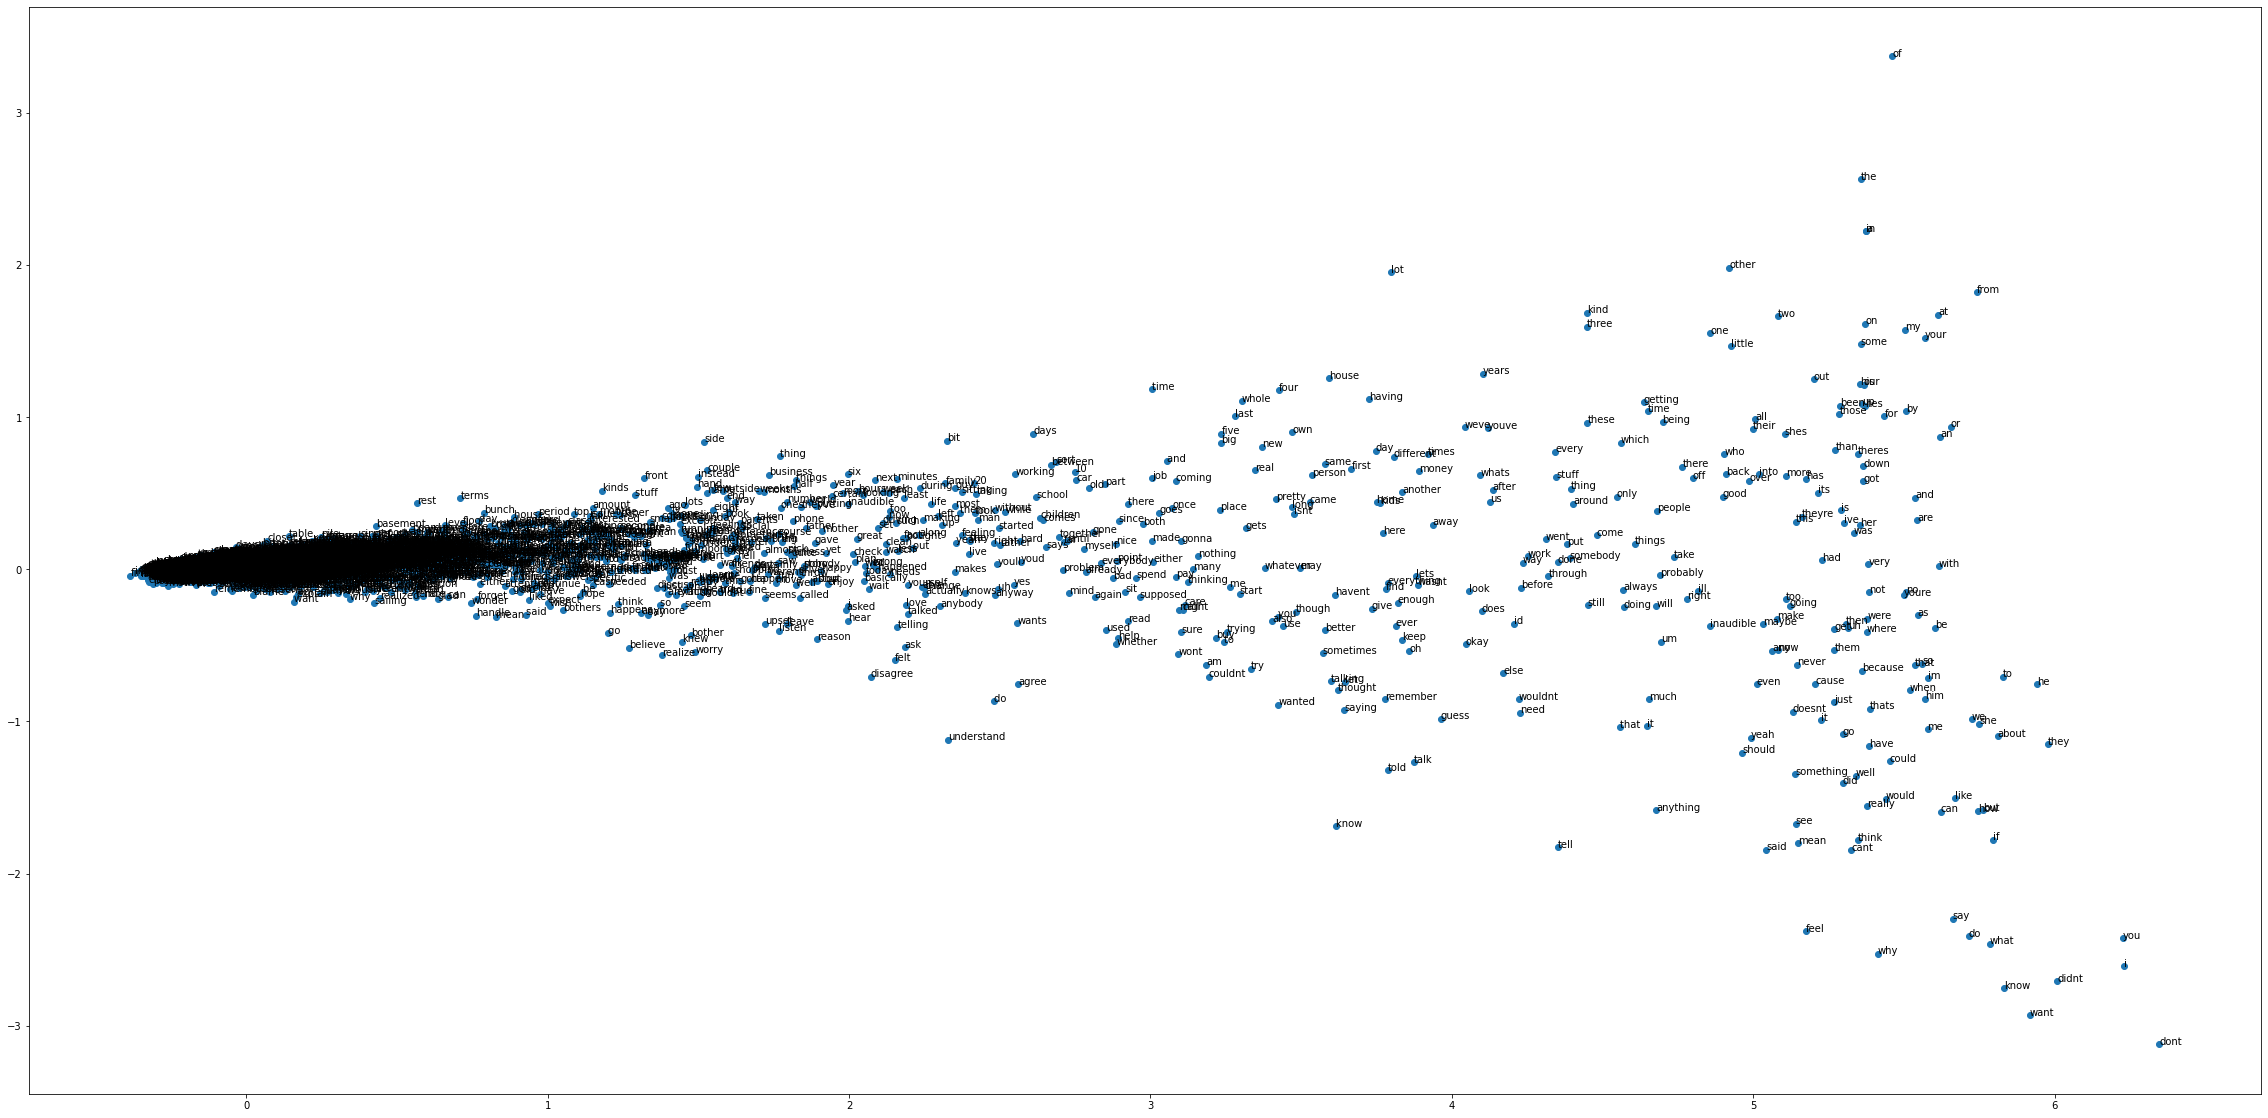

In [257]:
# train model
spaff_model = Word2Vec(spaff_split_utterances, min_count=1, size=300)
spaff_model.wv.save_word2vec_format('word2vec_trained_on_SPAFF.bin')
# fit a 2d PCA model to the vectors
X = spaff_model[spaff_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.figure(figsize=(40,20))

pyplot.scatter(result[:, 0], result[:, 1])
words = list(spaff_model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()


### Load in pretrained word2vec from Google for comparision

In [3]:
word2vec_path = '../word2vec/GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [16]:
def compare_embeddings(model, word2vec_model, pos_word, neg_word=None):

    if neg_word == None:
        result = model.most_similar(positive=[pos_word], topn=5)
        word2vec_result = word2vec_model.most_similar(positive=[pos_word], topn=5)
        print(f'Showing the most closest words in the embedding spaces to {pos_word}:')
    else:
        result = model.most_similar(positive=[pos_word], negative=[neg_word], topn=5)
        word2vec_result = word2vec_model.most_similar(positive=[pos_word], negative=[neg_word], topn=5)
        print(f'Showing the most closest words in the embedding spaces to {pos_word} - {neg_word}:')

    print('Manually trained word2vec:')
    print(result)
    print('Google trained word2vec:')
    print(word2vec_result)

In [52]:
compare_embeddings(spaff_model, word2vec_model, 'true')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to true:
SPAFF trained word2vec:
[('question', 0.9955716729164124), ('but', 0.9954984784126282), ('boring', 0.995166540145874), ('yeah', 0.9949766993522644), ('upsets', 0.99492347240448)]
Google trained word2vec:
[('truest', 0.5576050281524658), ('truer', 0.5481507778167725), ('truth', 0.5299649834632874), ('sounds_trite', 0.5245124101638794), ('Liyer_wish', 0.5177059173583984)]


### Bringing in IEMOCAP transcriptions to add to embedding train data

In [4]:
iemocap_dir = glob.glob('/Users/asi/connor_asi/iemocap_data/IEMOCAP_full_release/Session*/dialog/transcriptions/*')
iemocap_transcript = []

for i in iemocap_dir:
    f = open(i, "r")
    f = f.read()
    f = f.split('\n')
    for line in f:
        line = line.split(': ')[-1]
        line = line.translate(str.maketrans('','', string.punctuation)).lower()
        line = re.sub(' +', ' ', line)
        tokens = line.split(' ')
        iemocap_transcript.append(tokens)

### Reading in SWBD data for embedding training...

In [5]:
swbd_dir = glob.glob('/Users/asi/connor_asi/swbd_data/sw*/*')
swbd_transcript = []

total_swbd_transcript = []
for i in swbd_dir:
    f = open(i, "r")
    f = f.read()
    f = f.split('=======================================================================\n  \n\no          ')[-1]
    f = f.split('\n')
    swbd_transcript = []
    for line in f:
        line = line.split(':')[-1]
        line = line.split('/'[0])
        for i in line:
            utterance = []
            if i != '':
                i = i.translate(str.maketrans('','', string.punctuation)).lower()
                i = i.strip()
                i = re.sub(' +', ' ', i)
                if i != '':
                    i = i.split(' ')
                    i = [x for x in i if x != 'f']
                    i = [x for x in i if x != 'c']
                    i = [x for x in i if x != 'd']
                    i = [x for x in i if x != 'e']
                    i = [x for x in i if x != 'w']
                    swbd_transcript.append(i)
    total_swbd_transcript.append(swbd_transcript)
total_swbd_utterances = [item for sublist in total_swbd_transcript for item in sublist]

### Concat all flatten transcripts into one list of utterances for embedding training

In [6]:
print('Number of SPAFF utterances: ', len(spaff_split_utterances))
print('Number of IEMOCAP utterances: ', len(iemocap_transcript))
print('Number of SWBD utterances: ', len(total_swbd_utterances))

final = spaff_split_utterances + iemocap_transcript + total_swbd_utterances
print('Total number of utterances: ', len(final))

words = [item for sublist in final for item in sublist]
unique_words = set(words)
print('Number of words: ', len(words))
print('Number of unique words: ', len(unique_words))

Number of SPAFF utterances:  17114
Number of IEMOCAP utterances:  10390
Number of SWBD utterances:  245095
Total number of utterances:  272599
Number of words:  1911806
Number of unique words:  28940


/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


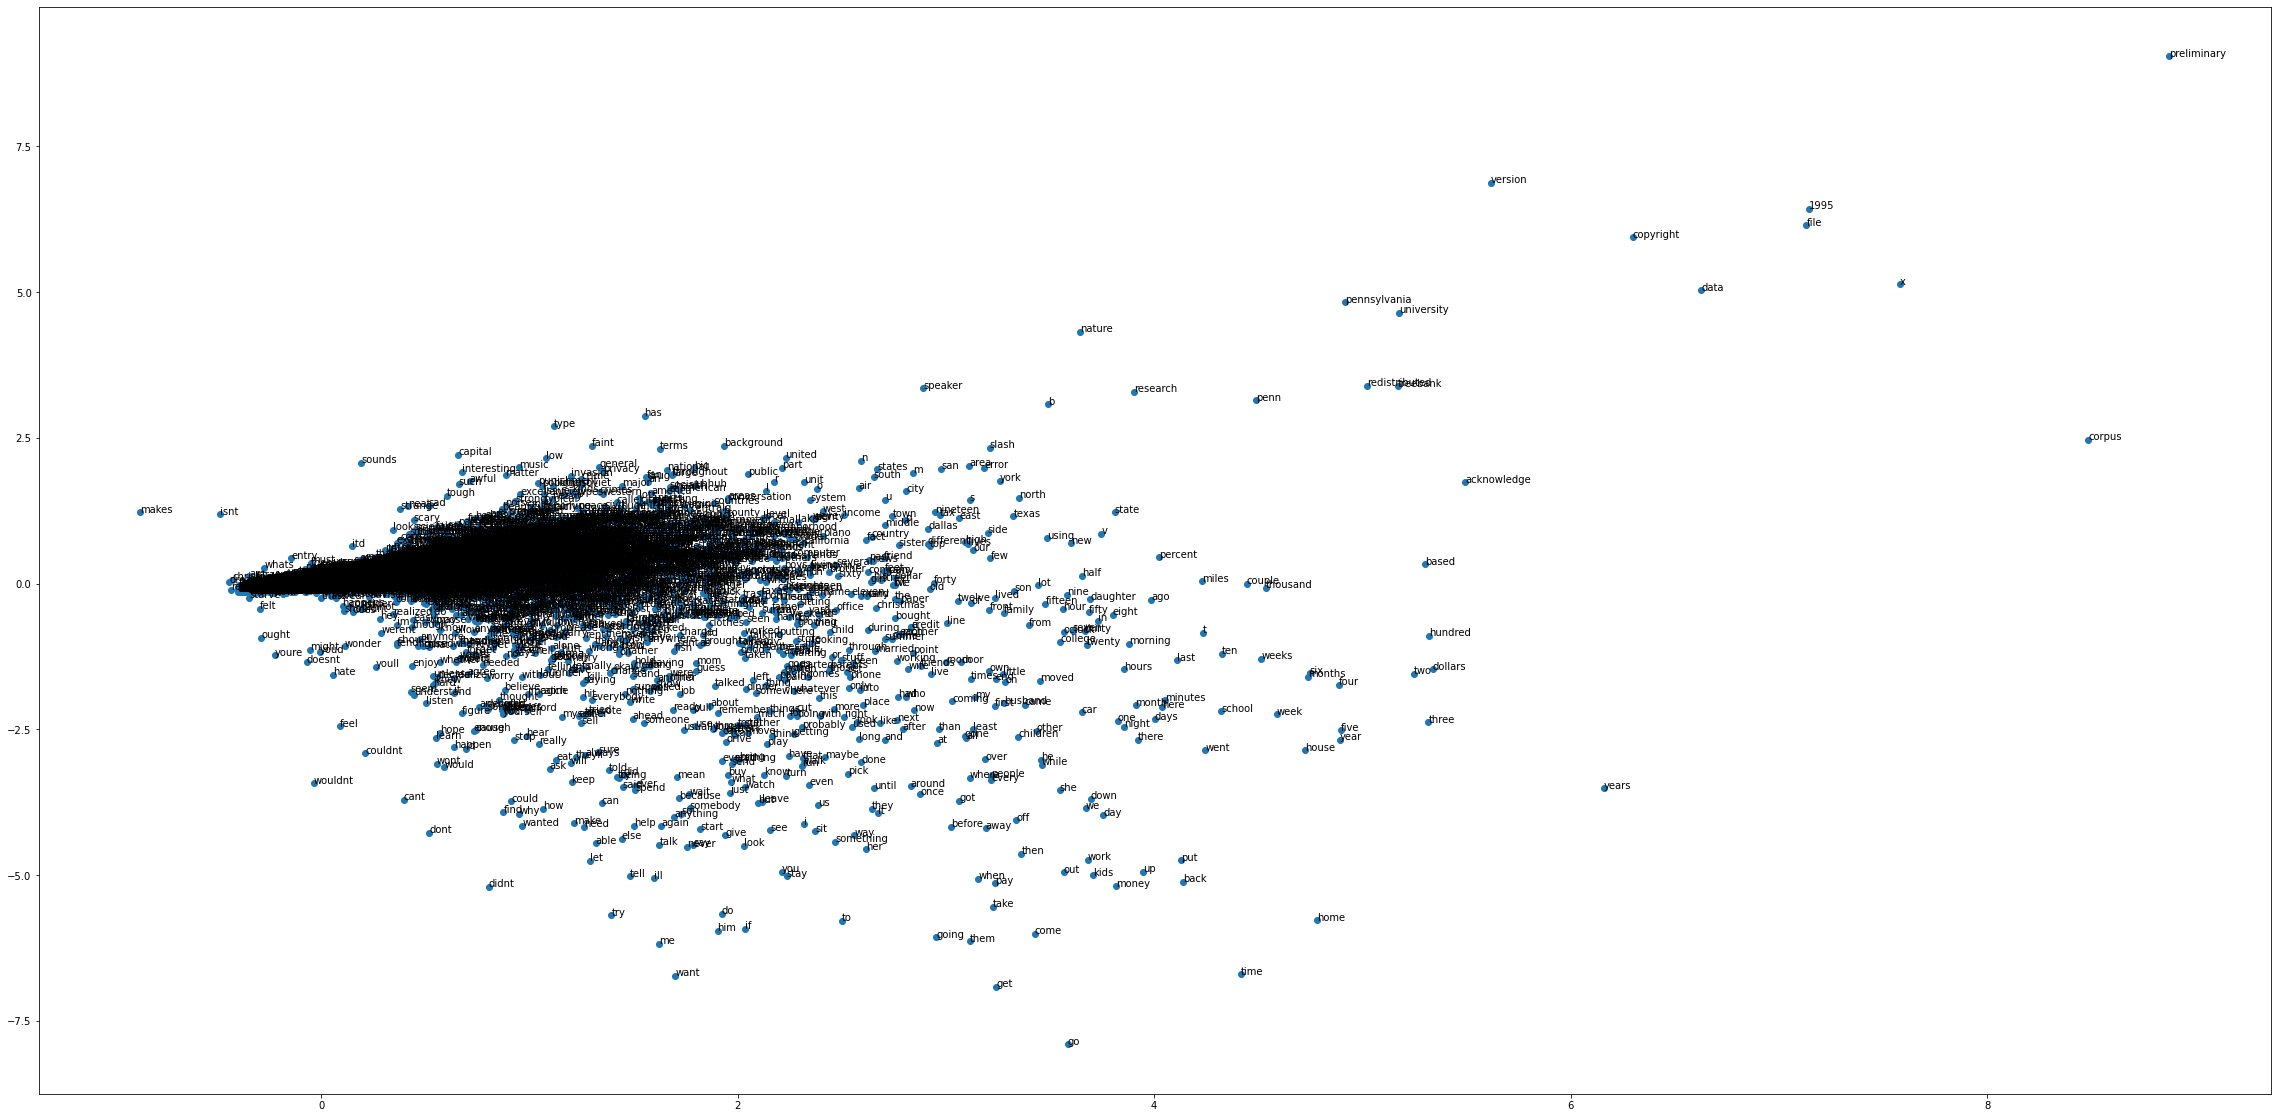

In [12]:
# train model
combined_model = Word2Vec(final, min_count=1, size=300)
combined_model.wv.save_word2vec_format('word2vec_trained_on_SPAFF_IEMOCAP_SWBD.bin')
combined_model.wv.save_word2vec_format('word2vec_trained_on_SPAFF_IEMOCAP_SWBD.txt', binary=False)

# fit a 2d PCA model to the vectors
X = combined_model[combined_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.figure(figsize=(40,20))

pyplot.scatter(result[:, 0], result[:, 1])
words = list(combined_model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [17]:
compare_embeddings(combined_model, word2vec_model, 'true')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to true:
Manually trained word2vec:
[('tha', 0.7489973306655884), ('awesome', 0.7433610558509827), ('true ', 0.7421762943267822), ('necessary', 0.7365281581878662), ('sad', 0.7344599962234497)]
Google trained word2vec:
[('truest', 0.5576050281524658), ('truer', 0.5481507778167725), ('truth', 0.5299649834632874), ('sounds_trite', 0.5245124101638794), ('Liyer_wish', 0.5177059173583984)]


In [18]:
compare_embeddings(combined_model, word2vec_model, 'yeah')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to yeah:
Manually trained word2vec:
[('yes', 0.8504761457443237), ('gee', 0.8364652395248413), ('jeez', 0.8303484916687012), ('wow', 0.8164548873901367), ('uhhuh', 0.8022724986076355)]
Google trained word2vec:
[('Yeah', 0.8202893733978271), ('hey', 0.7681265473365784), ('kinda', 0.7533951997756958), ('geez', 0.727707028388977), ('maybe', 0.7192153930664062)]


In [20]:
compare_embeddings(combined_model, word2vec_model, 'perfect')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to perfect:
Manually trained word2vec:
[('sorry ', 0.8453642129898071), ('moore', 0.8443278074264526), ('poverty', 0.8323951363563538), ('liberals', 0.8282331824302673), ('liking', 0.8262935876846313)]
Google trained word2vec:
[('ideal', 0.6970142126083374), ('pefect', 0.560092031955719), ('terrific', 0.5593017339706421), ('flawless', 0.5581796765327454), ('fabulous', 0.54146409034729)]


In [21]:
compare_embeddings(combined_model, word2vec_model, 'we')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to we:
Manually trained word2vec:
[('they', 0.6051191091537476), ('i', 0.5157508850097656), ('website', 0.49205049872398376), ('reservation', 0.4758991301059723), ('you', 0.47534996271133423)]
Google trained word2vec:
[('We', 0.7046471834182739), ('I', 0.6991738677024841), ('our', 0.6748816967010498), ('ourselves', 0.6614254713058472), ('you', 0.6565827131271362)]


In [22]:
compare_embeddings(combined_model, word2vec_model, 'interesting')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to interesting:
Manually trained word2vec:
[('funny', 0.7978829741477966), ('sad', 0.7825188636779785), ('helpful', 0.7773834466934204), ('neat', 0.7607384920120239), ('scary', 0.7505661249160767)]
Google trained word2vec:
[('intriguing', 0.8185973167419434), ('fascinating', 0.762306809425354), ('exciting', 0.666785717010498), ('Interesting', 0.6602181196212769), ('intersting', 0.6464772820472717)]


In [23]:
compare_embeddings(combined_model, word2vec_model, 'definitely')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to definitely:
Manually trained word2vec:
[('certainly', 0.8029060363769531), ('diminish', 0.7033520936965942), ('cheerfully', 0.694585382938385), ('admit', 0.6926001310348511), ('unsolved', 0.6395355463027954)]
Google trained word2vec:
[('certainly', 0.7688270211219788), ('obviously', 0.7471979856491089), ('really', 0.7389695048332214), ('Definitely', 0.7378983497619629), ('probably', 0.6752912998199463)]


In [24]:
compare_embeddings(combined_model, word2vec_model, 'love')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to love:
Manually trained word2vec:
[('hate', 0.6979982256889343), ('butnothing', 0.6587618589401245), ('agree', 0.5772452354431152), ('cook', 0.5524005889892578), ('origina', 0.5501981973648071)]
Google trained word2vec:
[('loved', 0.6907792091369629), ('adore', 0.6816873550415039), ('loves', 0.661863386631012), ('passion', 0.6100709438323975), ('hate', 0.600395679473877)]


In [25]:
compare_embeddings(combined_model, word2vec_model, 'mad')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to mad:
Manually trained word2vec:
[('angry', 0.814105749130249), ('shocked', 0.8047542572021484), ('amazed', 0.7408635020256042), ('aghast', 0.7327274084091187), ('jupiter', 0.7309863567352295)]
Google trained word2vec:
[('crazy', 0.7385838627815247), ('bonkers', 0.6324929594993591), ('stupid', 0.6125738620758057), ('pissed', 0.6093641519546509), ('insane', 0.6059296131134033)]


In [26]:
compare_embeddings(combined_model, word2vec_model, 'funny')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to funny:
Manually trained word2vec:
[('scary', 0.8898875713348389), ('sad', 0.8769237399101257), ('strange', 0.8383228182792664), ('neat', 0.8343999981880188), ('weird', 0.8255953788757324)]
Google trained word2vec:
[('hilarious', 0.7953873872756958), ('humorous', 0.7306495904922485), ('hilariously_funny', 0.7174550890922546), ('amusing', 0.7145007848739624), ('found_loophole_Conk', 0.7030782699584961)]


In [27]:
compare_embeddings(combined_model, word2vec_model, 'sad')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to sad:
Manually trained word2vec:
[('scary', 0.9338756799697876), ('strange', 0.9027504920959473), ('neat', 0.9010165929794312), ('frightening', 0.8928182125091553), ('funny', 0.876923680305481)]
Google trained word2vec:
[('saddening', 0.7273085713386536), ('Sad', 0.6610826253890991), ('saddened', 0.6604381799697876), ('heartbreaking', 0.6573508381843567), ('disheartening', 0.6507317423820496)]


In [28]:
compare_embeddings(combined_model, word2vec_model, 'great')

/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


Showing the most closest words in the embedding spaces to great:
Manually trained word2vec:
[('wonderful', 0.8278695344924927), ('terrible', 0.737801730632782), ('tough', 0.6750680208206177), ('neat', 0.6727763414382935), ('good', 0.6699866056442261)]
Google trained word2vec:
[('terrific', 0.798933207988739), ('fantastic', 0.7935211658477783), ('tremendous', 0.7748855948448181), ('wonderful', 0.7647868394851685), ('good', 0.7291510105133057)]


### Adding pronoun based n-grams

In [145]:
def make_ngram(utterance_list):
    pronoun_list = [
        'i',
        'im',
        'ill',
        'id',
        'ive',
        'me',
        'my',
        'mine',
        'myself',
        'we',
        'wed',
        'weve',
        'us',
        'our',
        'ours',
        'ourselves',
        'lets',
        'you',
        'your',
        'youre',
        'youd',
        'youve',
        'youll',
        'yours',
        'yourself',
        'yourselves',
        'he',
        'him',
        'his',
        'himself',
        'hed',
        'she',
        'her',
        'hers',
        'herself',
        'shell',
        'shed',
        'it',
        'its',
        'itll',
        'itself',
        'they',
        'them',
        'their',
        'theyre',
        'themselves',
        'yall'
    ]
    ngram_utterances = []
    for utt in utterance_list:
        utt_ = utt.copy()
        for word in utt_:
            if word in pronoun_list:
                idx = utt_.index(f'{word}')
                try:
                    bigram = f'{utt_[idx]}' + '_' + f'{utt_[idx+1]}'
                    utt_.pop(idx)
                    utt_.pop(idx)
                    utt_.insert(idx, bigram)
                except:
                    pass
        ngram_utterances.append(utt_)
        
    return ngram_utterances

In [146]:
spaff_split_utterances_ngrams = make_ngram(spaff_split_utterances)
iemocap_split_utterances_ngrams = make_ngram(iemocap_transcript)
swbd_split_utterances_ngrams = make_ngram(total_swbd_utterances)

In [147]:
print('Number of SPAFF utterances: ', len(spaff_split_utterances_ngrams))
print('Number of IEMOCAP utterances: ', len(iemocap_split_utterances_ngrams))
print('Number of SWBD utterances: ', len(swbd_split_utterances_ngrams))

final = spaff_split_utterances_ngrams + iemocap_split_utterances_ngrams + swbd_split_utterances_ngrams
print('Total number of utterances: ', len(final))

words = [item for sublist in final for item in sublist]
unique_words = set(words)
print('Number of words: ', len(words))
print('Number of unique words: ', len(unique_words))

Number of SPAFF utterances:  17114
Number of IEMOCAP utterances:  10390
Number of SWBD utterances:  245095
Total number of utterances:  272599
Number of words:  1655289
Number of unique words:  48628


/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/asi/anaconda3/envs/nlp/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


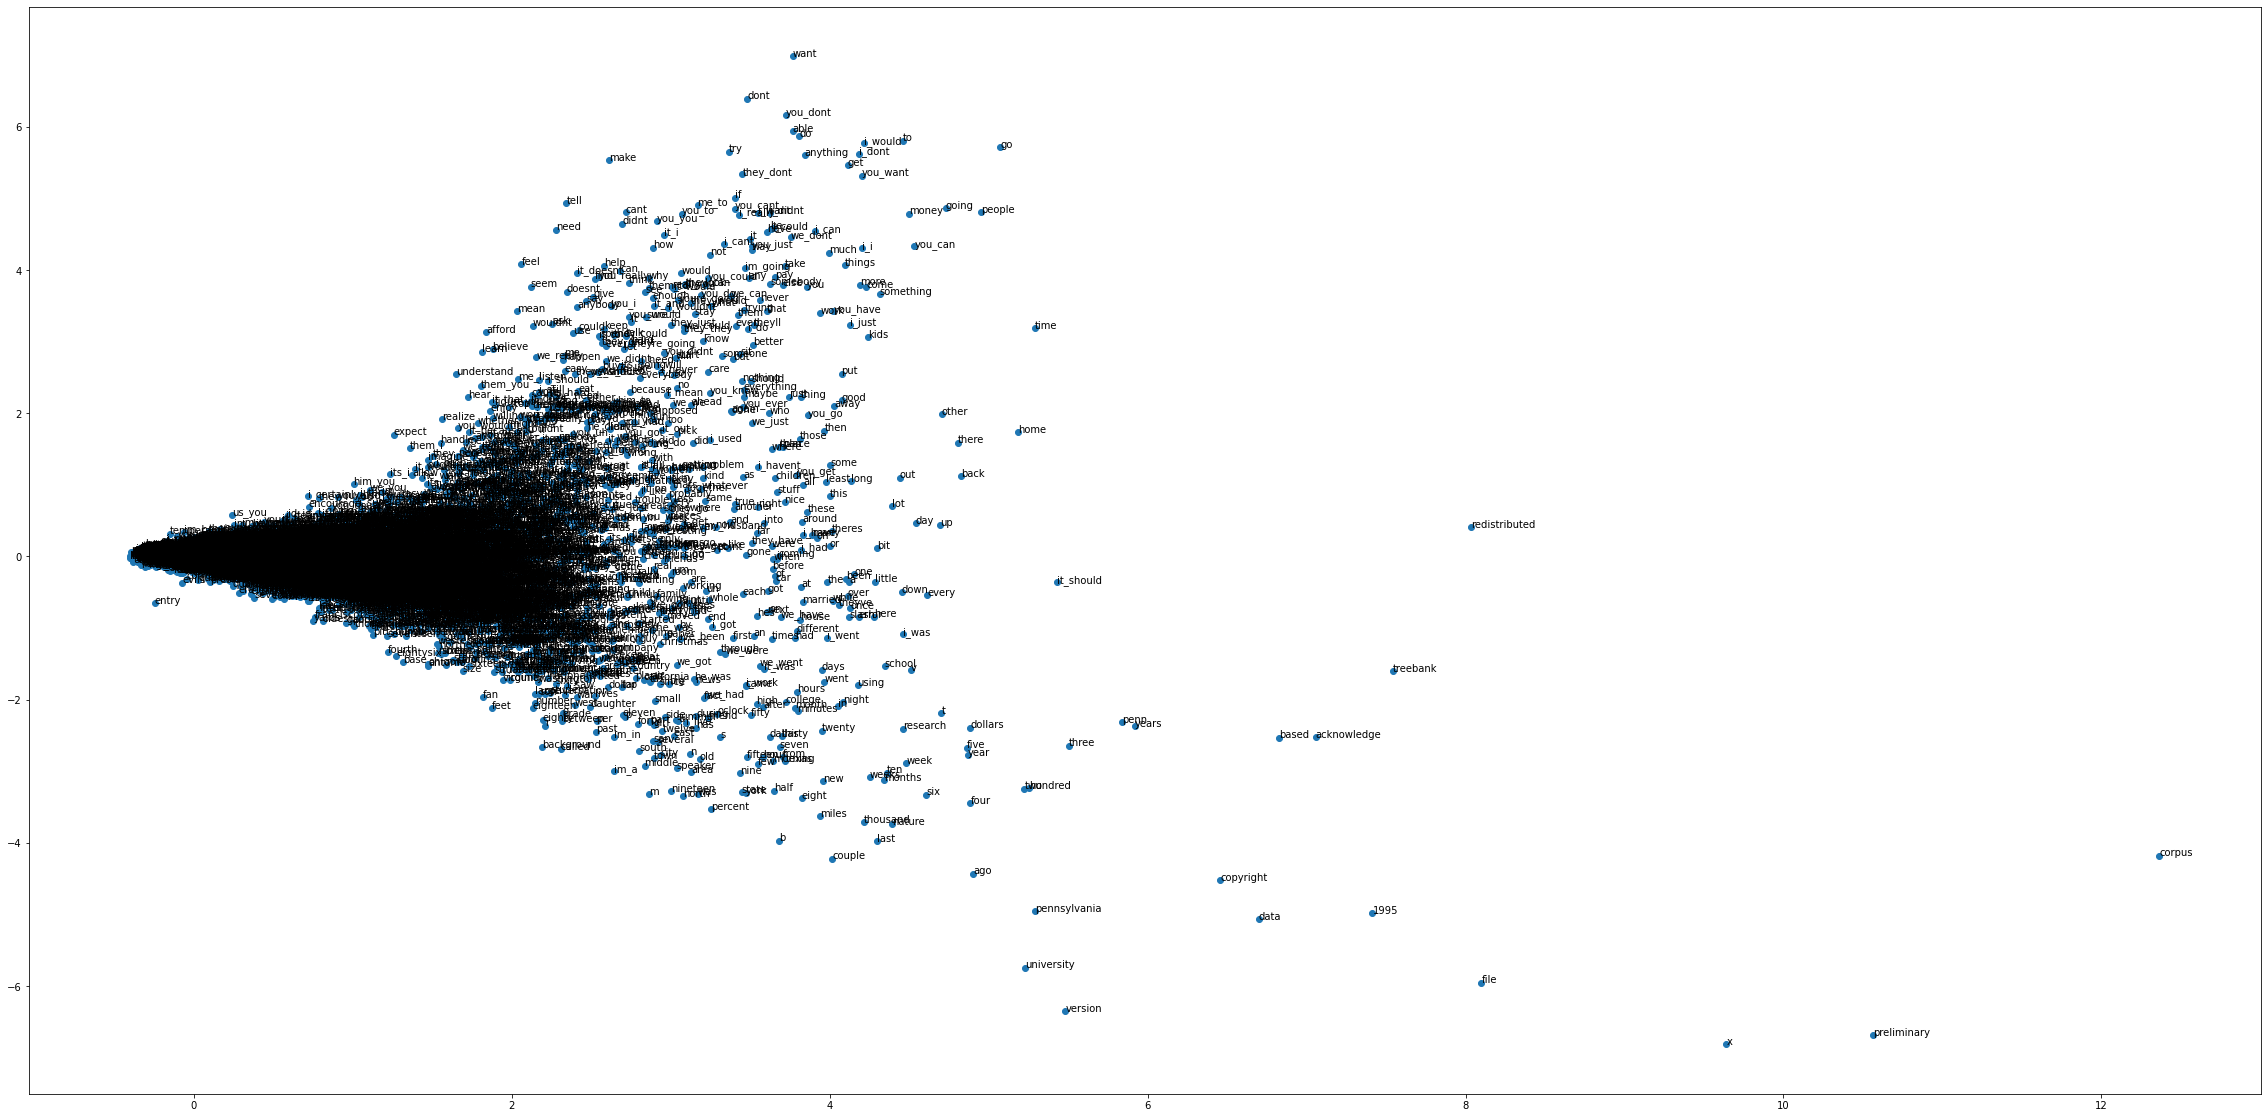

In [148]:
# train model
combined_model = Word2Vec(final, min_count=1, size=300)
combined_model.wv.save_word2vec_format('word2vec_trained_on_SPAFF_IEMOCAP_SWBD_ngrams.bin')
combined_model.wv.save_word2vec_format('word2vec_trained_on_SPAFF_IEMOCAP_SWBD_ngrams.txt', binary=False)

# fit a 2d PCA model to the vectors
X = combined_model[combined_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.figure(figsize=(40,20))

pyplot.scatter(result[:, 0], result[:, 1])
words = list(combined_model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()